SIDE NOTE: would love to get any critiques, hints, tips, oberservations on any level not just on ML (but obviously ML as the priority).  Beginner Python learner (though I took the Full Stack Course) so any suggestions there are welcome.  Thanks.

Will need to import these libs plus setting some global variables

In [1]:
import sys
import os
import numpy as np
import renders as rs
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.externals import joblib
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import SVC
import matplotlib.cm as cm
# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

os.chdir('/Users/senzari/Machine_Learning/stats/src')
#print(os.getcwd())

from stats import form_data, match_stats, model_libs, form_model, predict_matches

# Variables
round_number = 27 # for MLS only
target_col = 'points'
ignore_cols = ['games_played', 'match_id', 'team_id', 'team_name', 'opp_id', 'opp_name', 'scheduled']
models = ['log', 'svc', 'gmm', 'knn', 'gnb']

""" this variable 'testing' should be false if using CSV's and not pulling from the database. """
testing = False

INITIALIZED...


Pulling in the data either from the Database or the CSV (CSV for testers).  Data has some added features in between the database and 'raw_data'.

In [3]:
match_details = form_data.get_coverage()
print(match_details.shape)
pd.set_option('display.max_columns', 500)
display(match_details.head())

(464, 43)


,match_id,scheduled,round,home_team,home_id,home_formation,home_score,home_points,home_first_half_score,home_second_half_score,home_attacks,home_ball_safe,home_corner_kicks,home_dangerous_attacks,home_fouls,home_offsides,home_yellow_card,home_shots_on_target,home_shots_total,home_possession,home_goal_attempts,home_saves,home_goal_kicks,away_team,away_id,away_formation,away_score,away_points,away_first_half_score,away_second_half_score,away_attacks,away_ball_safe,away_corner_kicks,away_dangerous_attacks,away_fouls,away_offsides,away_yellow_card,away_shots_on_target,away_shots_total,away_possession,away_goal_attempts,away_saves,away_goal_kicks
0,1,2016-03-06 18:30:00,1,NY Red Bulls,31,4-2-3-1,0,0,0,0,143.0,115.0,2.0,77.0,12.0,4.0,1.0,0.0,7.0,48.0,7.0,3.0,7.0,Toronto FC,34,4-3-3,2,3,0,2,111.0,128.0,4.0,50.0,9.0,5.0,2.0,6.0,10.0,52.0,10.0,0.0,14.0
1,2,2016-03-06 19:00:00,1,Orlando City SC,35,4-3-3,2,1,0,2,NaN,45.0,12.0,49.0,14.0,4.0,2.0,7.0,14.0,50.0,14.0,6.0,4.0,Real Salt Lake,23,4-2-3-1,2,1,1,1,NaN,50.0,2.0,34.0,11.0,1.0,2.0,4.0,8.0,50.0,8.0,5.0,7.0
2,3,2016-03-06 19:00:00,1,Chicago Fire,40,4-2-3-1,3,0,1,2,77.0,83.0,12.0,41.0,11.0,7.0,2.0,9.0,12.0,34.0,12.0,4.0,5.0,New York City FC,24,4-3-3,4,3,3,1,103.0,75.0,1.0,48.0,9.0,1.0,2.0,8.0,12.0,66.0,12.0,6.0,6.0
3,4,2016-03-06 20:00:00,1,Houston Dynamo,38,4-2-3-1,3,1,1,2,65.0,66.0,5.0,44.0,10.0,1.0,1.0,5.0,14.0,48.0,14.0,2.0,4.0,New England Revolution,36,4-2-3-1,3,1,1,2,74.0,75.0,2.0,51.0,17.0,4.0,2.0,6.0,13.0,52.0,13.0,1.0,10.0
4,5,2016-03-06 20:00:00,1,San Jose Earthquakes,32,4-4-2,1,3,0,1,88.0,75.0,3.0,41.0,15.0,1.0,2.0,3.0,3.0,52.0,3.0,6.0,10.0,Colorado Rapids,22,4-2-3-1,0,0,0,0,86.0,80.0,5.0,39.0,15.0,2.0,2.0,6.0,11.0,48.0,11.0,2.0,3.0


In [6]:
data_csv = 'raw_data.csv'

if testing:
    raw_data = form_data.run_data()
    raw_data.to_csv(data_csv)
    print("Raw Data Saved to CSV")
else:
    #Reading in a CSV adds the first index column
    raw_data = pd.read_csv(data_csv)
    raw_data = raw_data.drop(raw_data.columns[[0]], axis=1)

pd.set_option("display.max_columns", 85)

# Removes Columns to Ignore and Splits the Target Column
def split_target(data):
    td = model_libs._clone_and_drop(data, ignore_cols)
    (y, X) = model_libs._extract_target(td, target_col)
    return X, y

raw_X, raw_y = split_target(raw_data)

display(raw_data.head())

print('Data Loaded...')

,match_id,team_id,team_name,opp_id,opp_name,scheduled,round,games_played,is_home,current_formation,current_record,opp_record,goals_for,opp_goals_for,goals_against,opp_goals_against,rpi,goals,points,current_team_possession,current_team_yellow_cards,current_team_goal_attempts,current_team_dangerous_attacks,current_team_sec_half_goals,current_team_saves,current_team_corner_kicks,current_team_ball_safe,current_team_first_half_goals,current_team_shots_on_target,current_team_attacks,current_team_goal_attempts_allowed,current_team_goal_kicks,current_team_shots_total,opp_team_possession,opp_team_yellow_cards,opp_team_goal_attempts,opp_team_dangerous_attacks,opp_team_sec_half_goals,opp_team_saves,opp_team_corner_kicks,opp_team_ball_safe,opp_team_first_half_goals,opp_team_shots_on_target,opp_team_attacks,opp_team_goal_attempts_allowed,opp_team_goal_kicks,opp_team_shots_total
0,249.0,21,FC Dallas,33.0,DC United,2016-03-26 21:30:00,4,3.0,0,4-2-3-1,0.666667,0.357143,4,2,5,5,0.630952,3.0,3.0,151.0,6.0,35.0,182.0,3,5.0,20.0,256.0,1,20.0,310.0,16.0,17.0,35.0,138.0,8.0,22.0,150.0,1,4.0,16.0,283.0,1,11.0,293.0,20.0,23.0,22.0
1,255.0,21,FC Dallas,39.0,Columbus Crew,2016-04-03 01:00:00,5,3.0,1,4-2-3-1,0.714286,0.166667,5,2,5,4,0.465919,1.0,1.0,152.0,7.0,32.0,169.0,3,5.0,14.0,284.0,2,17.0,336.0,19.0,16.0,32.0,171.0,3.0,39.0,194.0,2,12.0,22.0,248.0,0,18.0,289.0,22.0,15.0,37.0
2,265.0,21,FC Dallas,32.0,San Jose Earthquakes,2016-04-10 01:00:00,6,3.0,1,4-4-2,0.833333,0.500000,6,4,1,5,0.547723,2.0,1.0,148.0,6.0,45.0,168.0,4,9.0,10.0,286.0,2,19.0,339.0,19.0,17.0,45.0,145.0,7.0,19.0,151.0,2,7.0,11.0,308.0,2,11.0,309.0,28.0,31.0,19.0
3,272.0,21,FC Dallas,30.0,Portland Timbers,2016-04-14 02:30:00,7,3.0,0,4-4-2,0.687500,0.357143,6,4,3,7,0.497669,3.0,3.0,154.0,8.0,41.0,145.0,3,8.0,15.0,270.0,3,17.0,310.0,21.0,16.0,41.0,143.0,8.0,24.0,164.0,4,9.0,27.0,273.0,0,11.0,300.0,23.0,19.0,24.0
4,282.0,21,FC Dallas,27.0,Sporting Kansas City,2016-04-17 23:00:00,7,3.0,1,4-4-2,0.687500,0.625000,6,4,3,2,0.497669,2.0,3.0,154.0,8.0,41.0,145.0,3,8.0,15.0,270.0,3,17.0,310.0,21.0,16.0,41.0,143.0,3.0,22.0,152.0,3,16.0,10.0,296.0,1,9.0,317.0,35.0,32.0,22.0


Data Loaded...


In [7]:
raw_data.describe()

,match_id,team_id,opp_id,round,games_played,is_home,current_record,opp_record,goals_for,opp_goals_for,goals_against,opp_goals_against,rpi,goals,points,current_team_possession,current_team_yellow_cards,current_team_goal_attempts,current_team_dangerous_attacks,current_team_sec_half_goals,current_team_saves,current_team_corner_kicks,current_team_ball_safe,current_team_first_half_goals,current_team_shots_on_target,current_team_attacks,current_team_goal_attempts_allowed,current_team_goal_kicks,current_team_shots_total,opp_team_possession,opp_team_yellow_cards,opp_team_goal_attempts,opp_team_dangerous_attacks,opp_team_sec_half_goals,opp_team_saves,opp_team_corner_kicks,opp_team_ball_safe,opp_team_first_half_goals,opp_team_shots_on_target,opp_team_attacks,opp_team_goal_attempts_allowed,opp_team_goal_kicks,opp_team_shots_total
count,634.000000,634.000000,634.000000,634.000000,634.0,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000
mean,328.523659,42.198738,42.198738,13.599369,3.0,0.500000,0.500743,0.500743,4.116719,4.116719,4.105678,4.105678,0.500409,1.400631,1.340694,149.989011,5.037736,27.732601,145.232601,2.384858,9.364815,14.860806,277.152015,1.731861,13.774725,292.444853,27.774725,26.291209,27.728938,149.989011,5.037736,27.732601,145.232601,2.384858,9.364815,14.860806,277.152015,1.731861,13.774725,292.444853,27.774725,26.291209,27.728938
std,205.832299,26.165018,26.165018,7.795190,0.0,0.500395,0.227672,0.227672,2.128332,2.128332,1.919353,1.919353,0.102546,1.205726,1.260914,12.937566,2.189004,5.789482,24.981303,1.458263,3.105601,4.723211,26.825820,1.450835,3.892166,36.884268,6.171239,5.930974,5.783875,12.937566,2.189004,5.789482,24.981303,1.458263,3.105601,4.723211,26.825820,1.450835,3.892166,36.884268,6.171239,5.930974,5.783875
min,28.000000,21.000000,21.000000,4.000000,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.212798,0.000000,0.000000,98.000000,0.000000,11.000000,67.000000,0.000000,1.000000,3.000000,193.000000,0.000000,3.000000,186.000000,9.000000,8.000000,11.000000,98.000000,0.000000,11.000000,67.000000,0.000000,1.000000,3.000000,193.000000,0.000000,3.000000,186.000000,9.000000,8.000000,11.000000
25%,258.000000,27.000000,27.000000,6.000000,3.0,0.000000,0.339286,0.339286,3.000000,3.000000,3.000000,3.000000,0.431136,1.000000,0.000000,143.000000,4.000000,24.000000,129.000000,1.000000,7.000000,12.000000,261.000000,1.000000,11.000000,269.000000,24.000000,22.000000,24.000000,143.000000,4.000000,24.000000,129.000000,1.000000,7.000000,12.000000,261.000000,1.000000,11.000000,269.000000,24.000000,22.000000,24.000000
50%,337.000000,33.000000,33.000000,12.000000,3.0,0.500000,0.500000,0.500000,4.000000,4.000000,4.000000,4.000000,0.504501,1.000000,1.000000,149.989011,5.000000,27.732601,145.232601,2.000000,9.364815,14.860806,277.152015,1.000000,13.774725,292.444853,27.774725,26.291209,27.728938,149.989011,5.000000,27.732601,145.232601,2.000000,9.364815,14.860806,277.152015,1.000000,13.774725,292.444853,27.774725,26.291209,27.728938
75%,434.000000,40.000000,40.000000,21.000000,3.0,1.000000,0.642857,0.642857,5.000000,5.000000,5.000000,5.000000,0.565580,2.000000,3.000000,157.000000,6.000000,31.000000,158.000000,3.000000,11.000000,17.000000,292.000000,3.000000,16.000000,311.000000,31.000000,30.000000,31.000000,157.000000,6.000000,31.000000,158.000000,3.000000,11.000000,17.000000,292.000000,3.000000,16.000000,311.000000,31.000000,30.000000,31.000000
max,893.000000,120.000000,120.000000,27.000000,3.0,1.000000,1.000000,1.000000,12.000000,12.000000,12.000000,12.000000,0.753571,7.000000,3.000000,210.000000,13.000000,54.000000,246.000000,8.000000,20.000000,32.00000

In [5]:
display(raw_data)

,match_id,team_id,team_name,opp_id,opp_name,scheduled,round,games_played,is_home,current_formation,current_record,opp_record,goals_for,opp_goals_for,goals_against,opp_goals_against,rpi,goals,points,current_team_possession,current_team_yellow_cards,current_team_goal_attempts,current_team_dangerous_attacks,current_team_sec_half_goals,current_team_saves,current_team_corner_kicks,current_team_ball_safe,current_team_first_half_goals,current_team_shots_on_target,current_team_attacks,current_team_goal_attempts_allowed,current_team_goal_kicks,current_team_shots_total,opp_team_possession,opp_team_yellow_cards,opp_team_goal_attempts,opp_team_dangerous_attacks,opp_team_sec_half_goals,opp_team_saves,opp_team_corner_kicks,opp_team_ball_safe,opp_team_first_half_goals,opp_team_shots_on_target,opp_team_attacks,opp_team_goal_attempts_allowed,opp_team_goal_kicks,opp_team_shots_total
0,249.0,21,FC Dallas,33.0,DC United,2016-03-26 21:30:00,4,3.0,0,4-2-3-1,0.666667,0.357143,4,2,5,5,0.630952,3.0,3.0,151.000000,6.000000,35.000000,182.000000,3,5.000000,20.000000,256.000000,1,20.000000,310.000000,16.000000,17.000000,35.000000,138.000000,8.000000,22.000000,150.000000,1,4.000000,16.000000,283.000000,1,11.000000,293.000000,20.000000,23.000000,22.000000
1,255.0,21,FC Dallas,39.0,Columbus Crew,2016-04-03 01:00:00,5,3.0,1,4-2-3-1,0.714286,0.166667,5,2,5,4,0.465919,1.0,1.0,152.000000,7.000000,32.000000,169.000000,3,5.000000,14.000000,284.000000,2,17.000000,336.000000,19.000000,16.000000,32.000000,171.000000,3.000000,39.000000,194.000000,2,12.000000,22.000000,248.000000,0,18.000000,289.000000,22.000000,15.000000,37.000000
2,265.0,21,FC Dallas,32.0,San Jose Earthquakes,2016-04-10 01:00:00,6,3.0,1,4-4-2,0.833333,0.500000,6,4,1,5,0.547723,2.0,1.0,148.000000,6.000000,45.000000,168.000000,4,9.000000,10.000000,286.000000,2,19.000000,339.000000,19.000000,17.000000,45.000000,145.000000,7.000000,19.000000,151.000000,2,7.000000,11.000000,308.000000,2,11.000000,309.000000,28.000000,31.000000,19.000000
3,272.0,21,FC Dallas,30.0,Portland Timbers,2016-04-14 02:30:00,7,3.0,0,4-4-2,0.687500,0.357143,6,4,3,7,0.497669,3.0,3.0,154.000000,8.000000,41.000000,145.000000,3,8.000000,15.000000,270.000000,3,17.000000,310.000000,21.000000,16.000000,41.000000,143.000000,8.000000,24.000000,164.000000,4,9.000000,27.000000,273.000000,0,11.000000,300.000000,23.000000,19.000000,24.000000
4,282.0,21,FC Dallas,27.0,Sporting Kansas City,2016-04-17 23:00:00,7,3.0,1,4-4-2,0.687500,0.625000,6,4,3,2,0.497669,2.0,3.0,154.000000,8.000000,41.000000,145.000000,3,8.000000,15.000000,270.000000,3,17.000000,310.000000,21.000000,16.000000,41.000000,143.000000,3.000000,22.000000,152.000000,3,16.000000,10.000000,296.000000,1,9.000000,317.000000,35.000000,32.000000,22.000000
5,289.0,21,FC Dallas,28.0,Vancouver Whitecaps FC,2016-04-24 02:30:00,8,3.0,0,4-4-2,0.833333,0.192308,7,0,4,5,0.526647,0.0,0.0,163.000000,9.000000,34.000000,140.000000,2,11.000000,21.000000,246.000000,5,15.000000,250.000000,27.000000,25.000000,34.000000,144.000000,3.000000,19.000000,139.000000,0,16.000000,11.000000,303.000000,0,9.000000,306.000000,43.000000,36.000000,19.000000
6,295.0,21,FC Dallas,31.0,NY Red Bulls,2016-04-29 23:00:00,9,3.0,0,4-4-2,0.714286,0.333333,5,4,5,6,0.507738,0.0,0.0,158.000000,7.000000,32.000000,162.000000,1,13.000000,18.000000,264.000000,4,14.000000,267.000000,32.000000,30.000000,32.000000,153.000000,6.000000,30.000000,210.000000,4,11.000000,20.000000,265.000000,0,16.000000,336.000000,31.000000,24.000000,30.000000
7,307.0,21,FC Dallas,34.0,Toronto FC,2016-05-07 23:30:00,10,3.0,0,4-2-3-1,0.333333,0.750000,2,4,8,2,0.541667,0.0,0.0,149.000000,4.000000,31.000000,171.000000,1,14.000000,16.000000,316.000000,1,14.000000,303.000000,38.000000,32.000000,31.000000,140.000000,4.000000,29.000000,157.000000,1,9.000000,15.000000,309.000000,3,17.000000,319.000000,28.000000,36.000000,29.000000
8,315.0,21,FC Dallas,30.0,Portland Timbers,2016-05-12 01:00:00,11,3.0,1,4-3-3,0.000000,0.500000,0,4,8,4,0.444643,2.0,3.0,155.000000,4.000000

In [6]:
home_score = pd.crosstab(match_details['home_score'], 
            match_details.replace({'home_points': {0: 'Lose', 1: 'Tie', 3: 'Win'}})['home_points']).apply(lambda r: r/len(match_details), axis=1)
home_score['Total'] = home_score.sum(axis=1)
home_score.loc['Total']= home_score.sum()
display(home_score)

home_points,Lose,Tie,Win,Total
home_score,,,,
0,0.114224,0.077586,0.000000,0.191810
1,0.096983,0.131466,0.116379,0.344828
2,0.015086,0.068966,0.170259,0.254310
3,0.006466,0.010776,0.114224,0.131466
4,0.000000,0.004310,0.045259,0.049569
5,0.000000,0.000000,0.017241,0.017241
6,0.000000,0.000000,0.010776,0.010776
Total,0.232759,0.293103,0.474138,1.000000


In [7]:
away_score = pd.crosstab(match_details['away_score'], 
            match_details.replace({'away_points': {0: 'Lose', 1: 'Tie', 3: 'Win'}})['away_points']).apply(lambda r: r/len(match_details), axis=1)

away_score['Total'] = away_score.sum(axis=1)
away_score.loc['Total'] = away_score.sum()
display(away_score)

away_points,Lose,Tie,Win,Total
away_score,,,,
0,0.245690,0.077586,0.000000,0.323276
1,0.163793,0.131466,0.047414,0.342672
2,0.056034,0.068966,0.088362,0.213362
3,0.006466,0.010776,0.053879,0.071121
4,0.002155,0.004310,0.034483,0.040948
5,0.000000,0.000000,0.004310,0.004310
6,0.000000,0.000000,0.002155,0.002155
7,0.000000,0.000000,0.002155,0.002155
Total,0.474138,0.293103,0.232759,1.000000


In [8]:
away_shots = pd.crosstab(match_details['away_score'], 
            match_details['away_shots_total'])

away_shots['Total'] = away_shots.sum(axis=1)
away_shots.loc['Total'] = away_shots.sum()
display(away_shots)

away_shots_total,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,Total
away_score,,,,,,,,,,,,,,,,,,,
0,2,1,2,14,20,19,17,16,17,13,12,4,4,0,1,0,2,0,144
1,0,3,8,14,14,21,29,10,17,12,8,5,4,3,0,1,0,1,150
2,0,0,1,5,6,7,13,10,12,15,8,4,4,3,3,2,1,1,95
3,0,0,0,1,0,1,5,7,4,4,2,3,3,0,0,1,0,0,31
4,0,0,0,1,1,0,4,0,2,1,2,3,1,1,1,1,0,0,18
5,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
Total,2,4,11,35,41,48,68,43,53,46,32,19,16,7,5,5,4,2,441


In [9]:
home_shots = pd.crosstab(match_details['home_score'], 
            match_details['home_shots_total'])

home_shots['Total'] = home_shots.sum(axis=1)
home_shots.loc['Total'] = home_shots.sum()
display(home_shots)

home_shots_total,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,24.0,Total
home_score,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,7,8,9,16,10,6,7,7,4,2,1,1,0,1,0,0,0,0,0,84
1,0,1,1,4,5,7,10,11,16,19,26,9,16,8,6,2,3,3,2,1,0,0,1,0,151
2,0,0,0,2,1,5,7,6,7,13,10,16,14,14,6,2,3,2,0,1,2,1,0,1,113
3,0,0,0,0,0,1,4,2,2,7,9,5,9,5,7,2,3,0,1,0,2,0,0,0,59
4,0,0,0,0,0,0,1,3,1,3,4,0,1,3,1,1,2,0,0,0,0,0,0,1,21
5,0,0,0,0,0,0,1,0,0,1,2,0,0,1,0,1,0,0,1,0,0,1,0,0,8
6,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,5
Total,1,2,2,7,7,20,31,31,42,53,57,37,48,35,22,10,12,5,6,3,4,3,1,2,441


## Features RELATIONSHIPS

,current_team_possession,current_team_attacks,current_team_dangerous_attacks,current_team_yellow_cards,current_team_corner_kicks,current_team_shots_on_target,current_team_ball_safe,current_team_goal_attempts,current_team_saves,current_team_goal_kicks,points
0,151.0,310.0,182.0,6.0,20.0,20.0,256.0,35.0,5.0,17.0,3.0
1,152.0,336.0,169.0,7.0,14.0,17.0,284.0,32.0,5.0,16.0,1.0
2,148.0,339.0,168.0,6.0,10.0,19.0,286.0,45.0,9.0,17.0,1.0
3,154.0,310.0,145.0,8.0,15.0,17.0,270.0,41.0,8.0,16.0,3.0
4,154.0,310.0,145.0,8.0,15.0,17.0,270.0,41.0,8.0,16.0,3.0


//anaconda/envs/stats/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


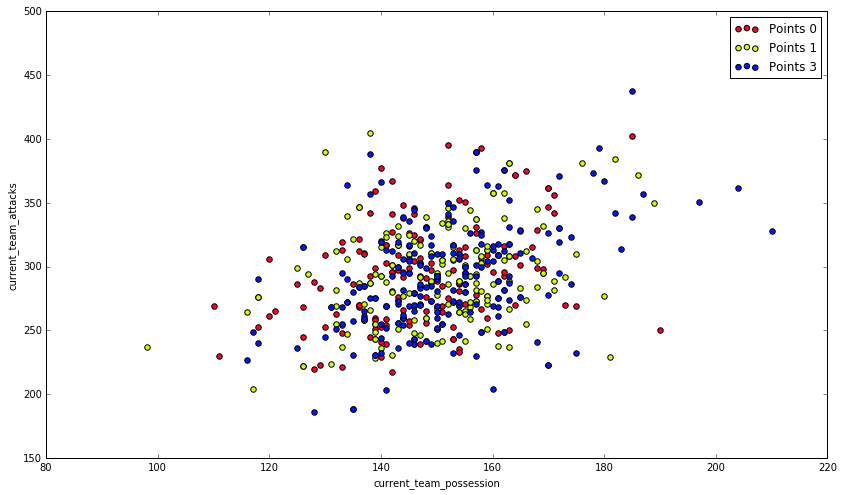

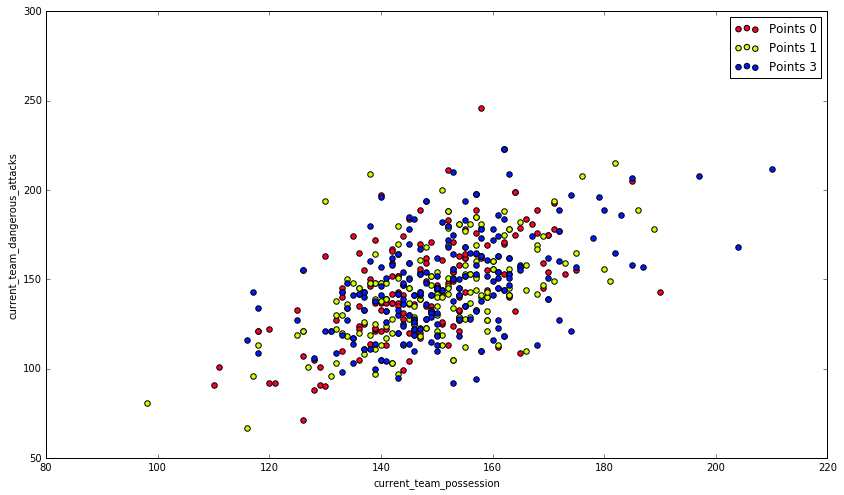

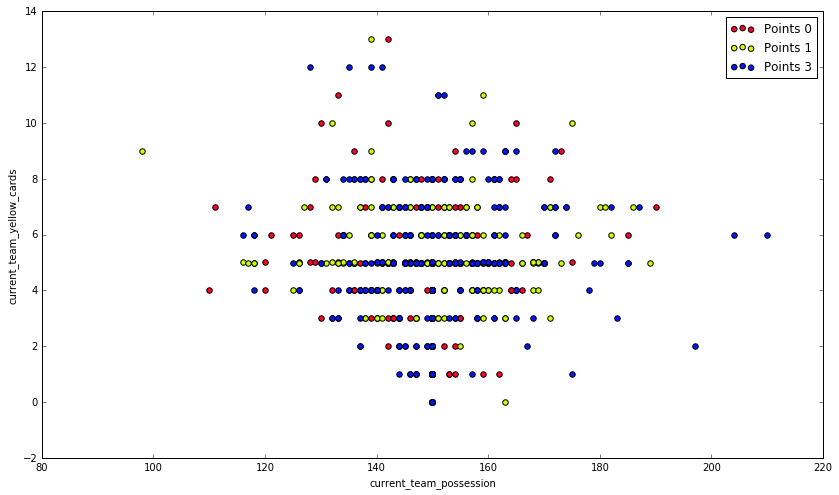

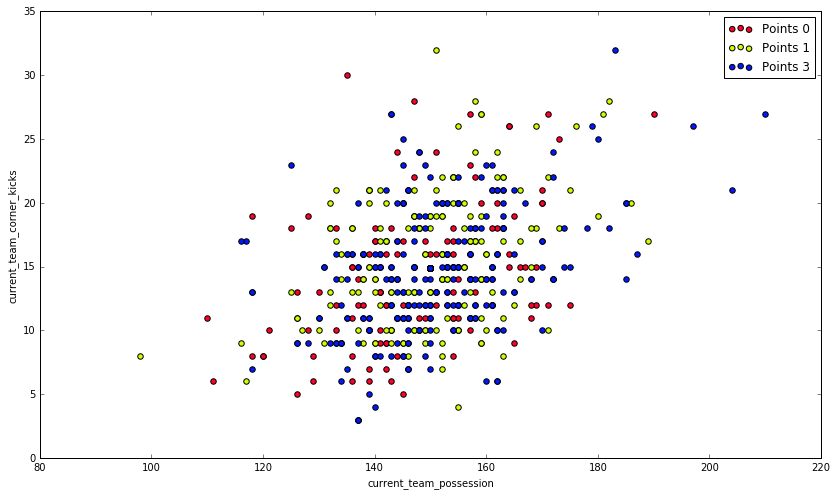

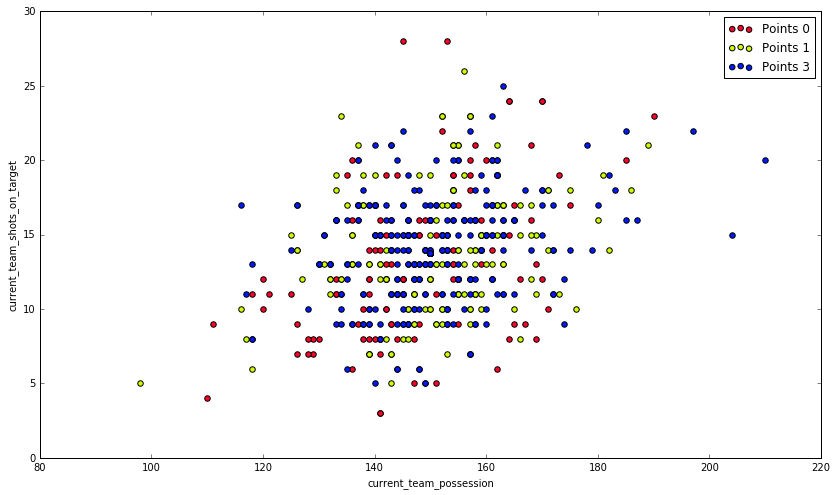

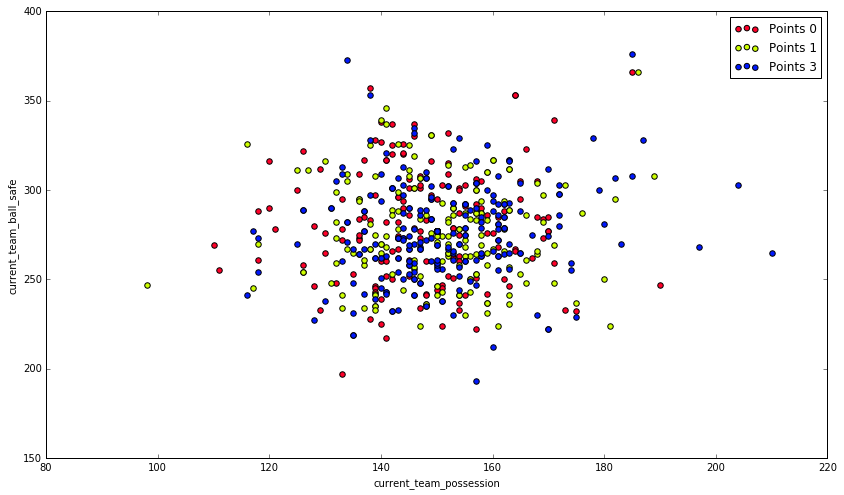

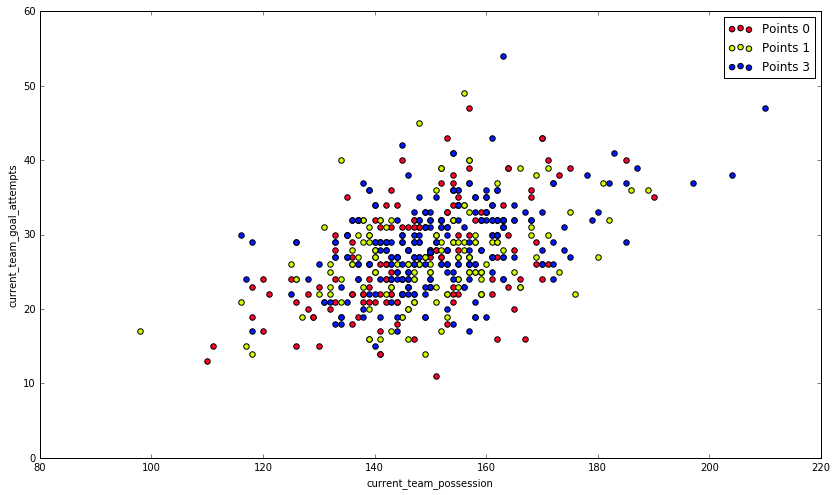

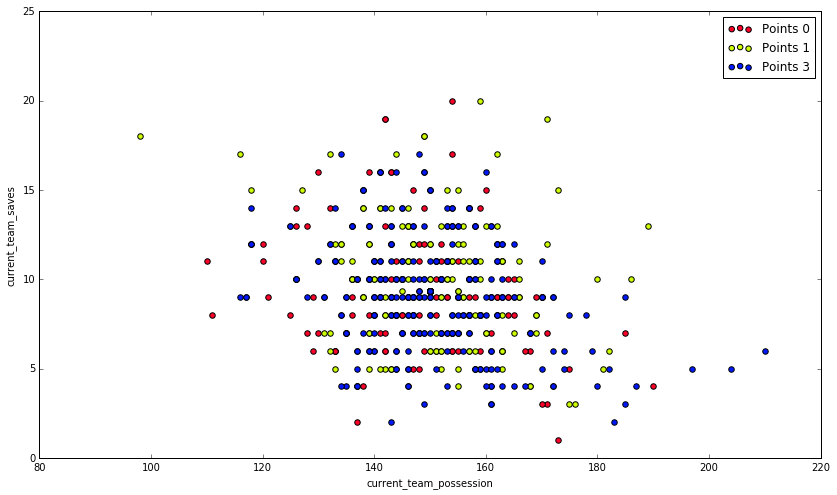

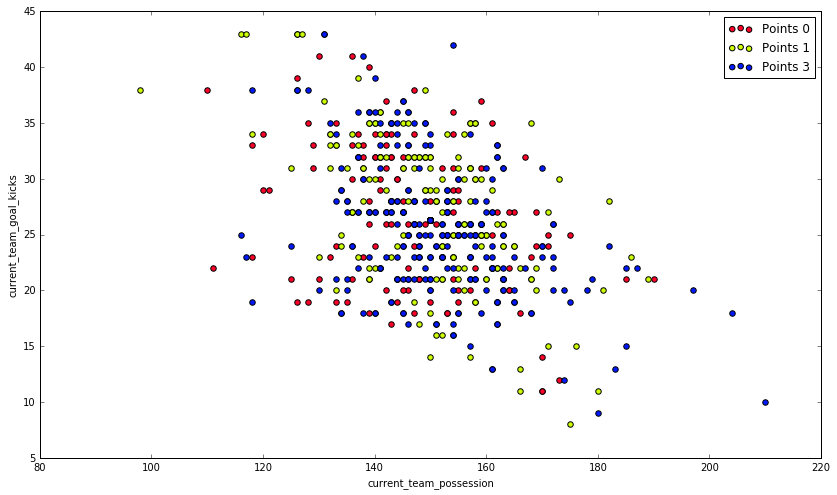

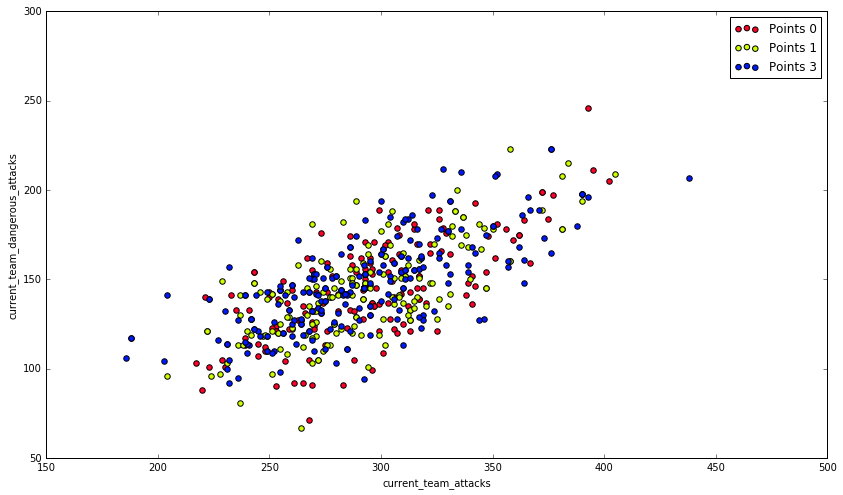

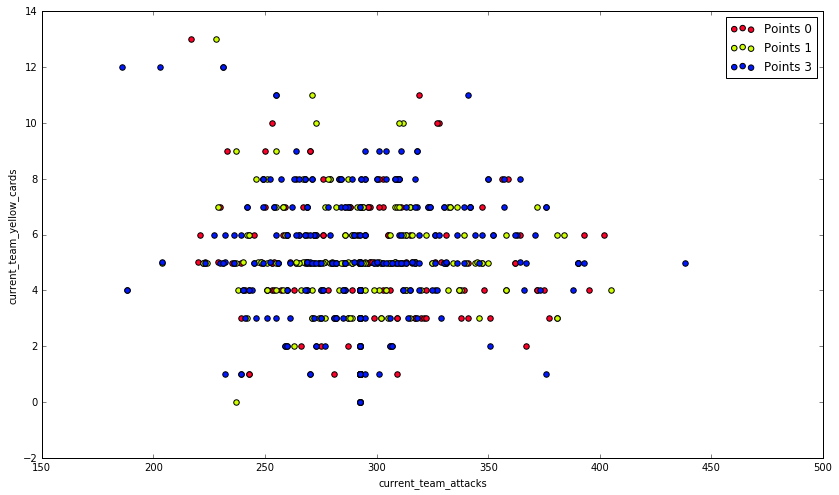

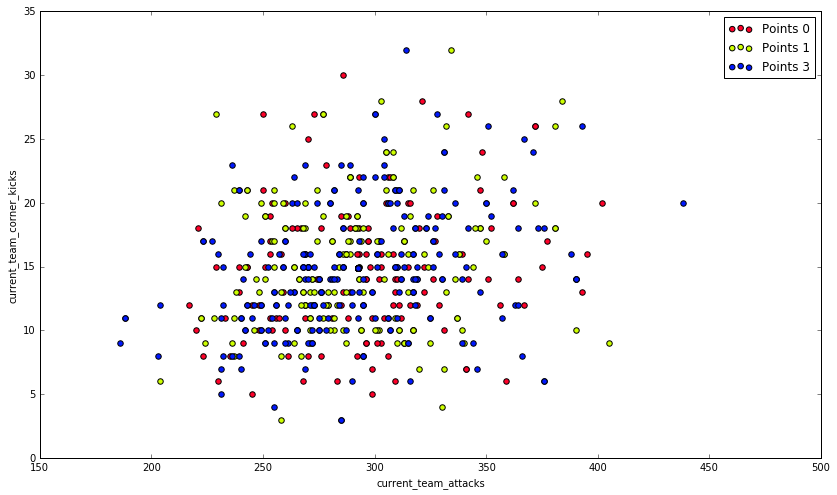

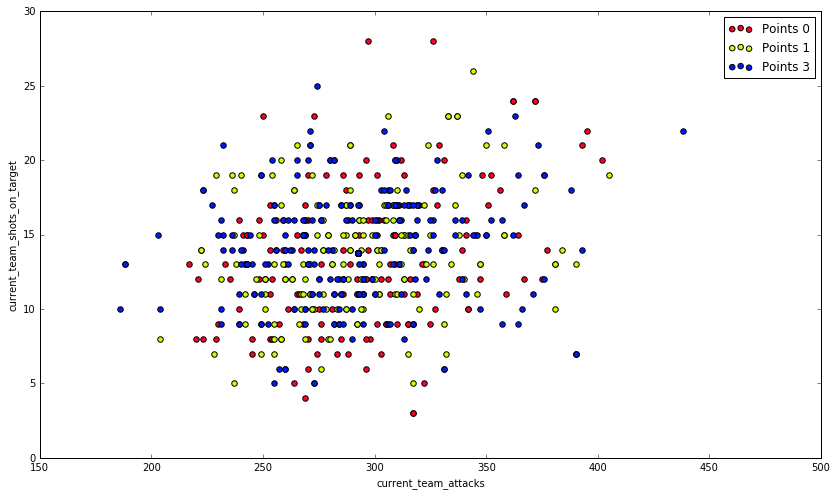

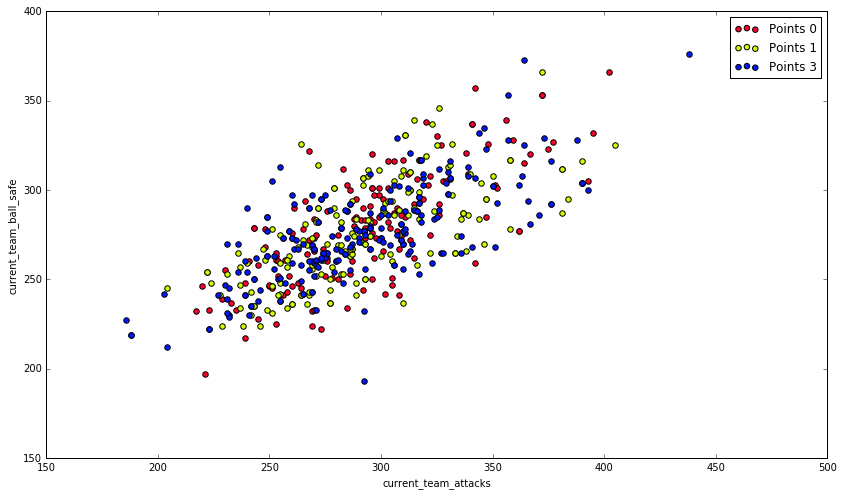

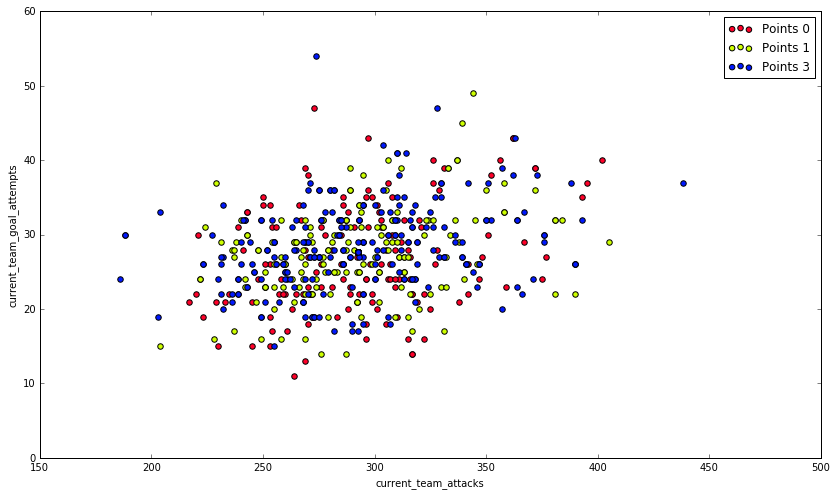

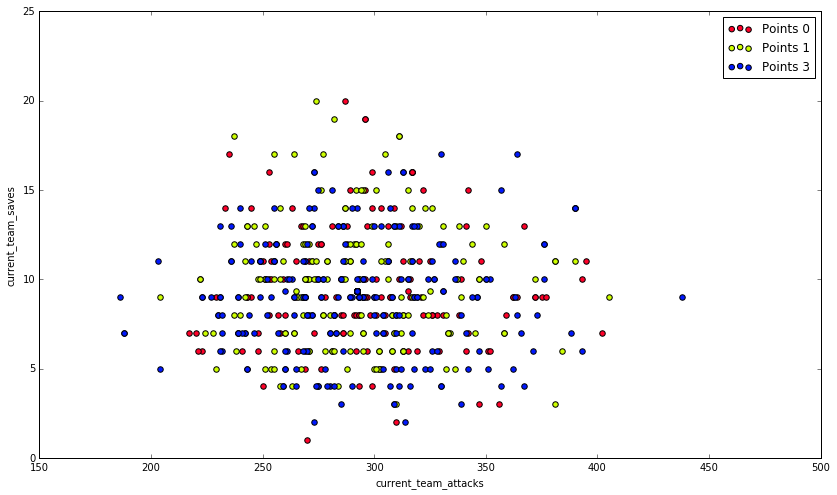

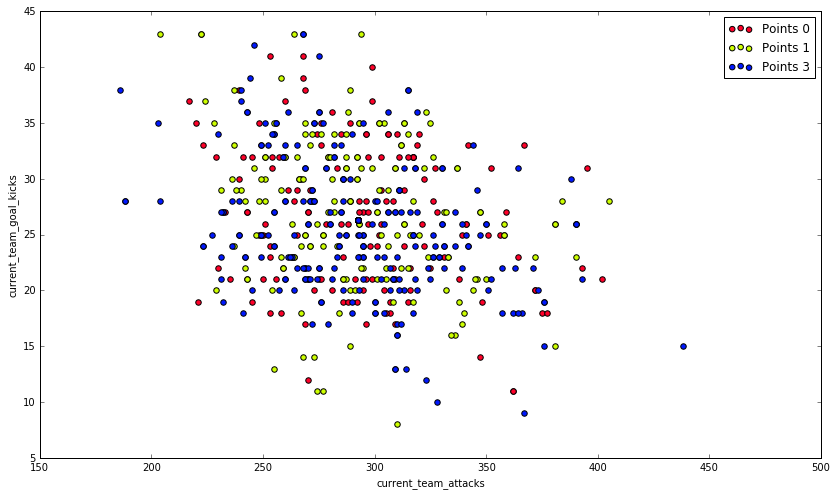

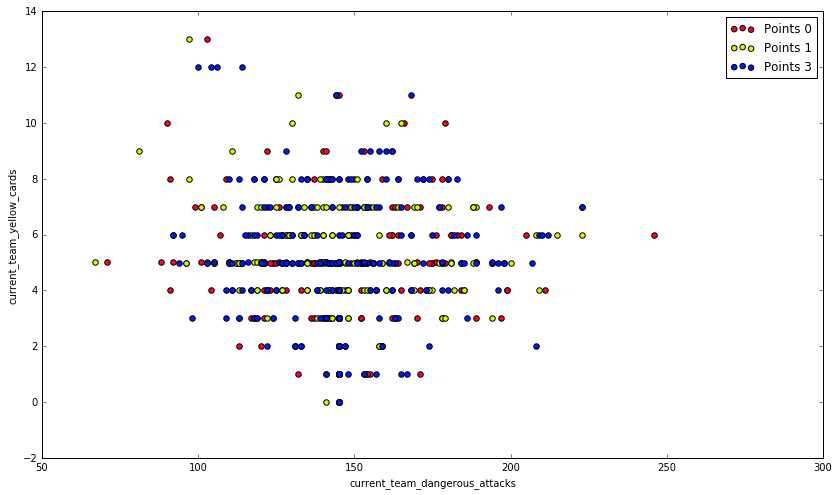

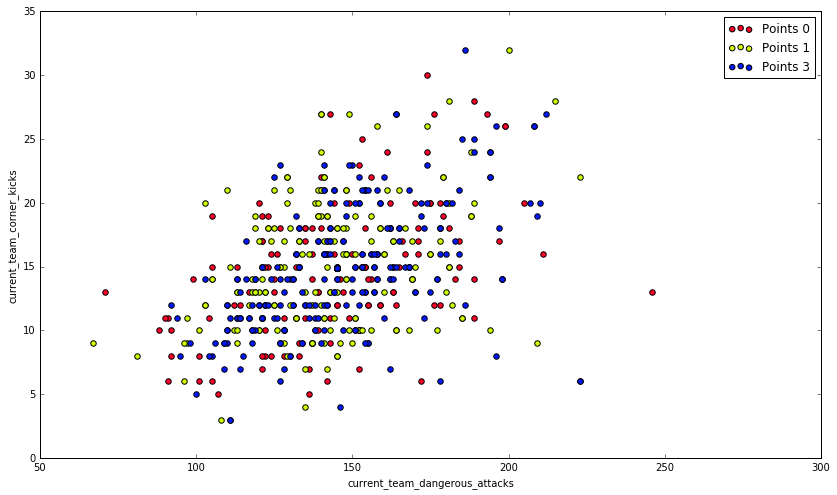

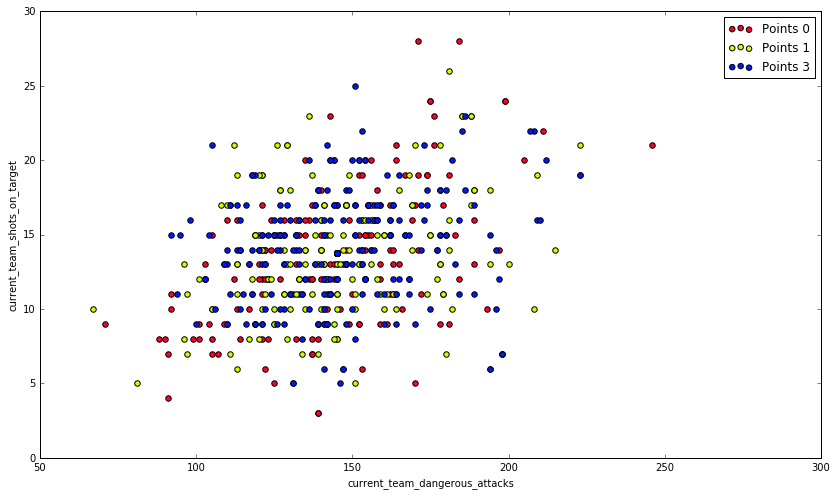

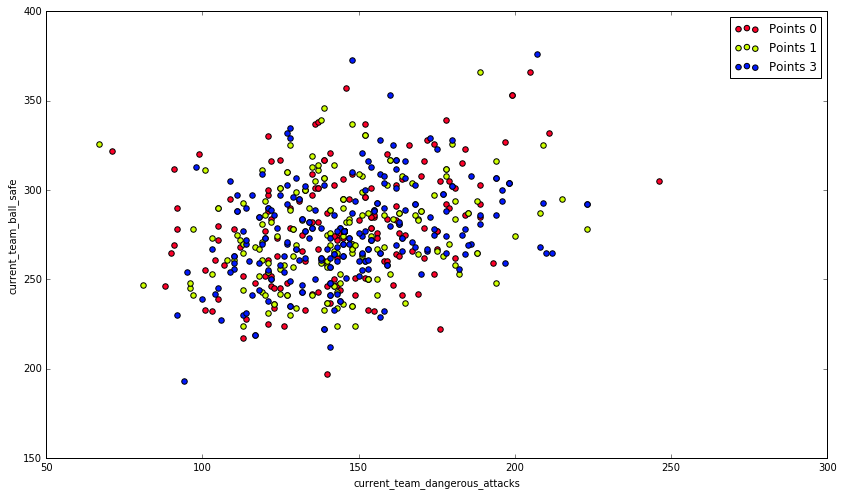

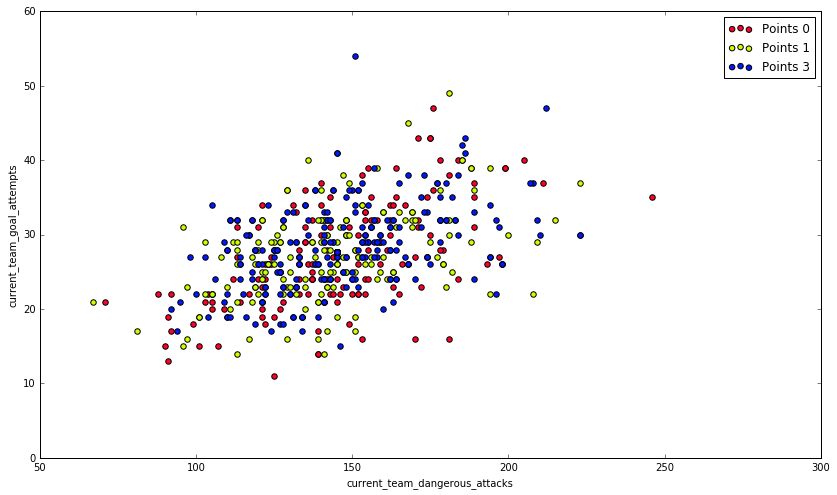

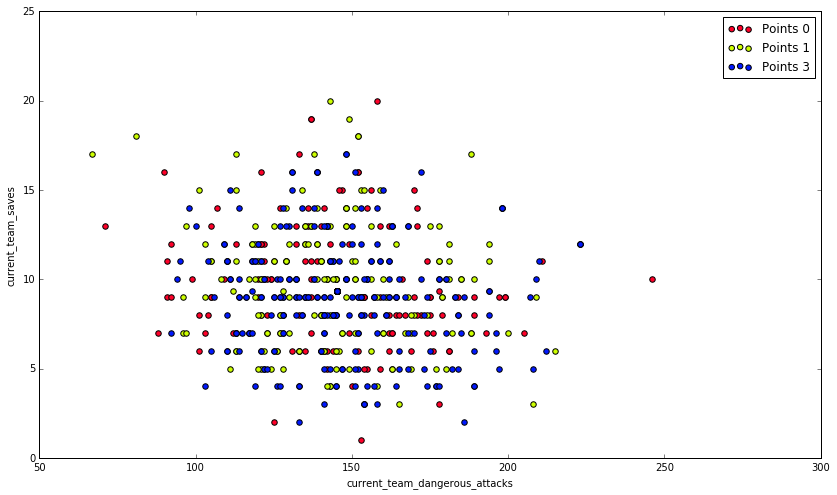

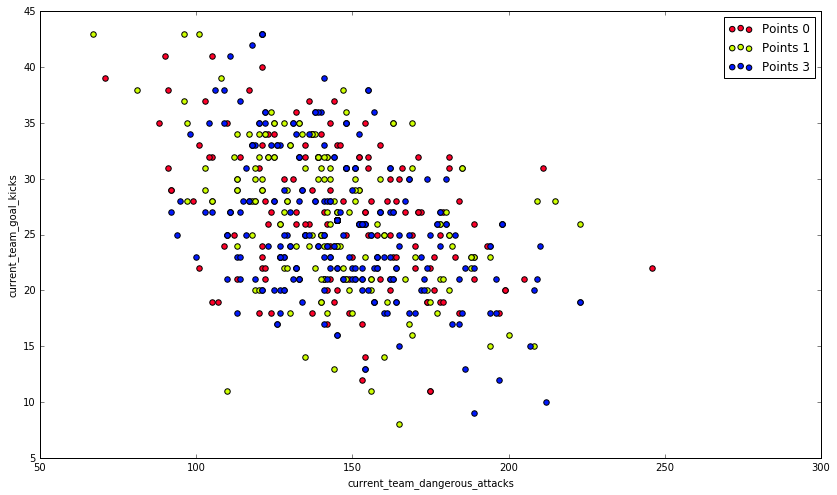

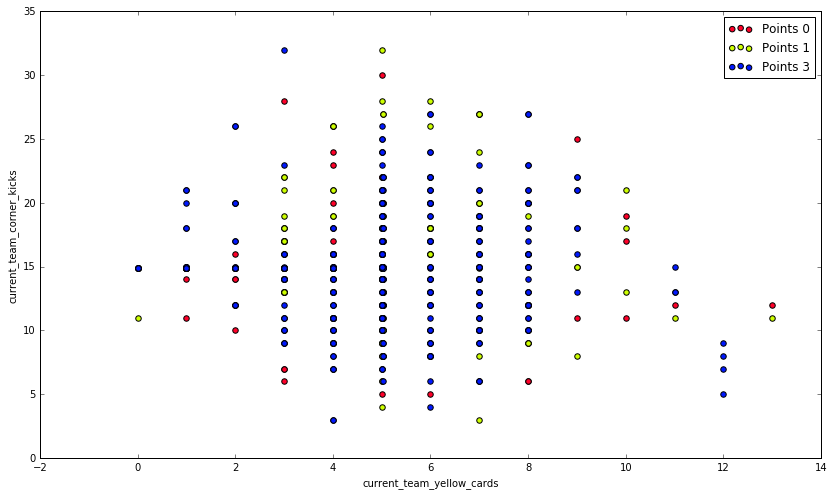

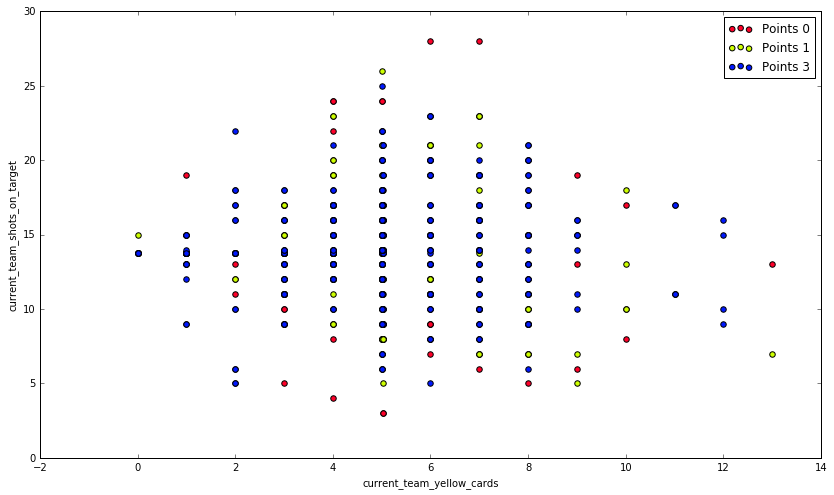

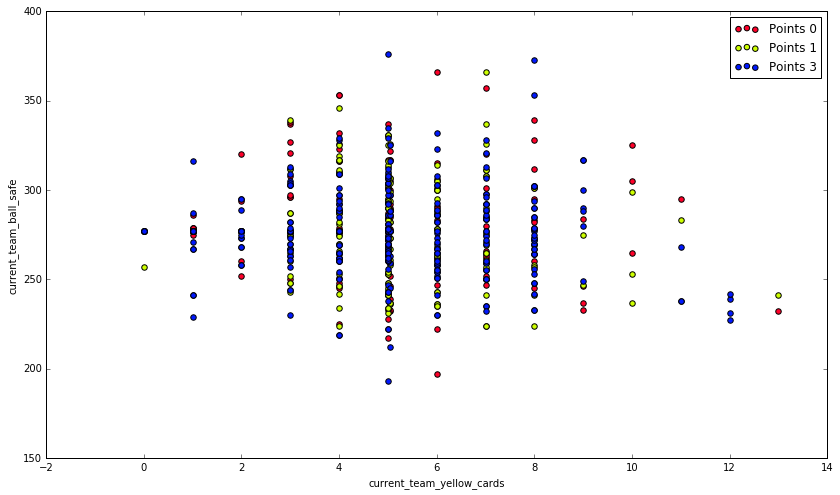

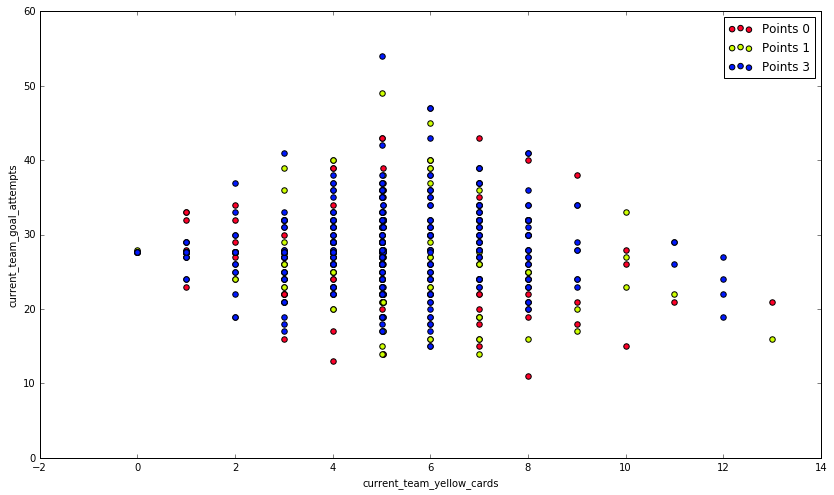

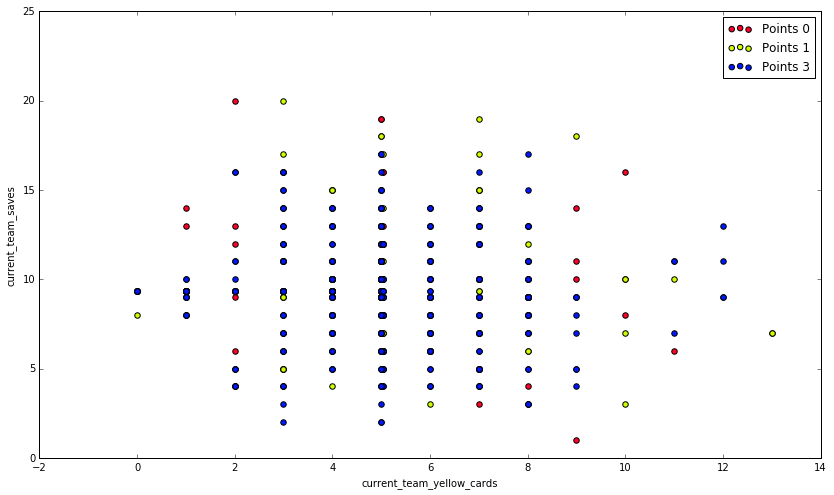

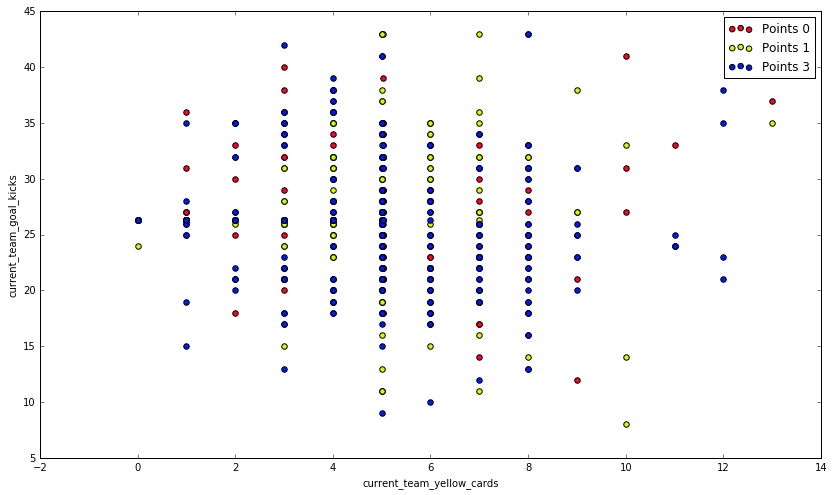

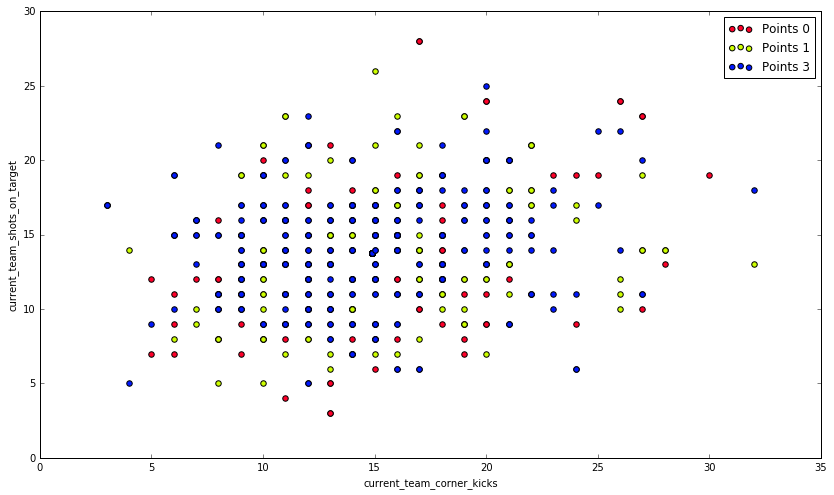

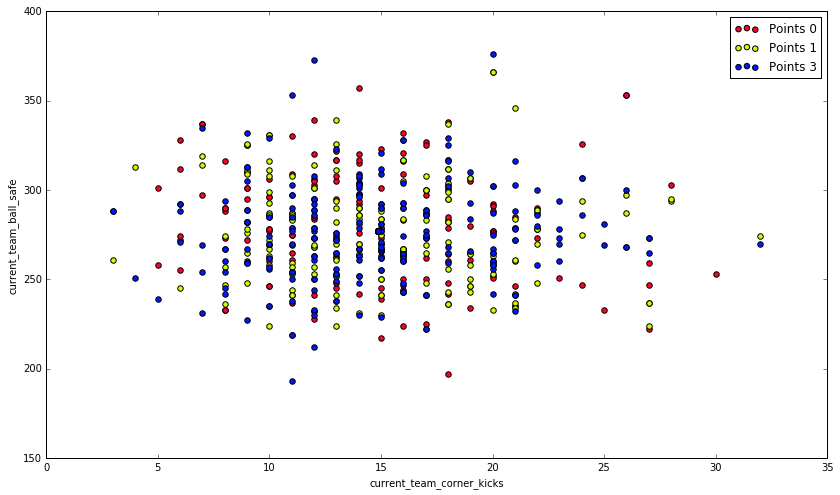

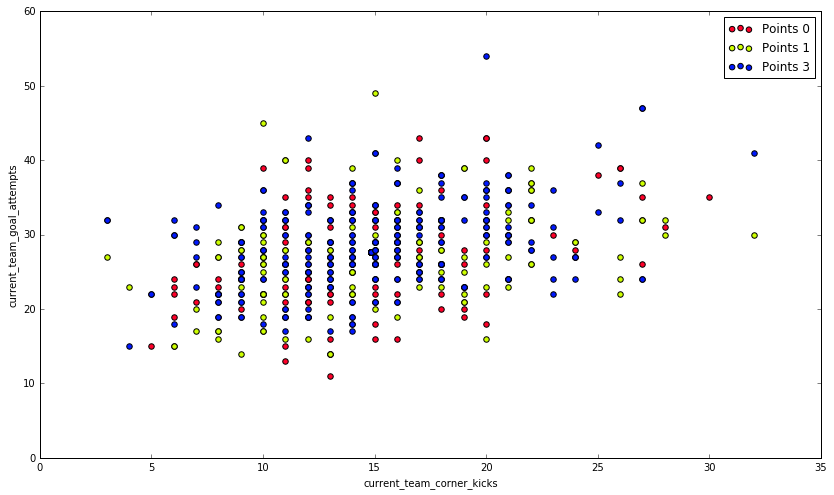

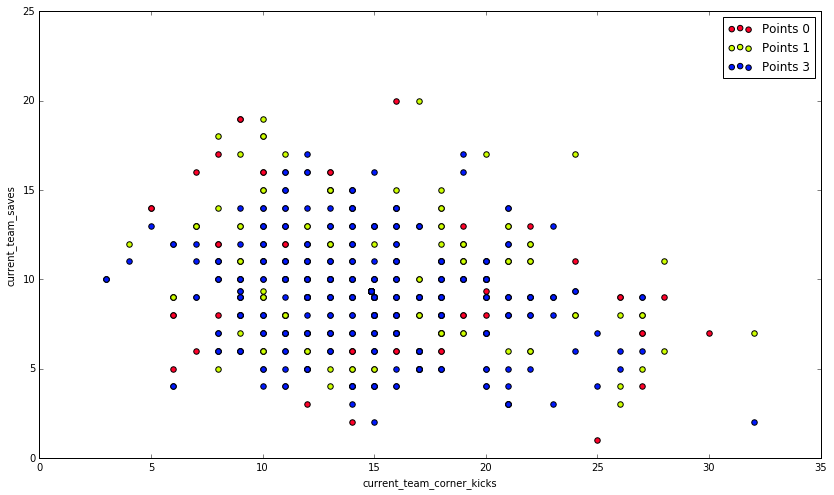

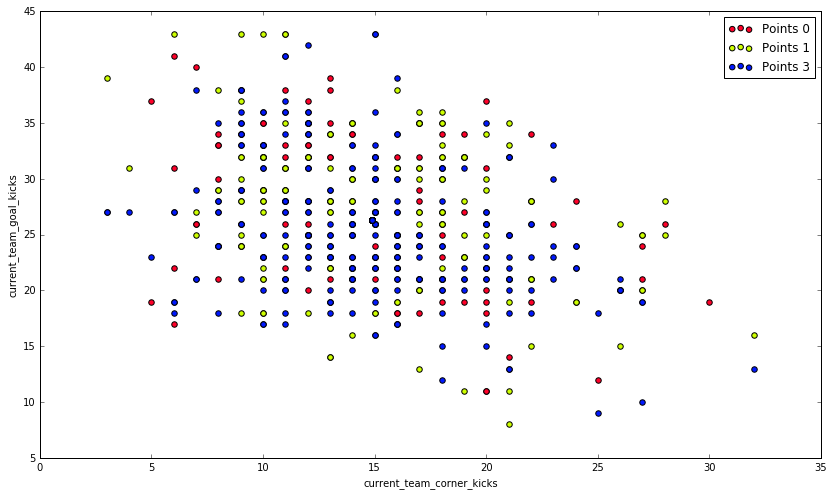

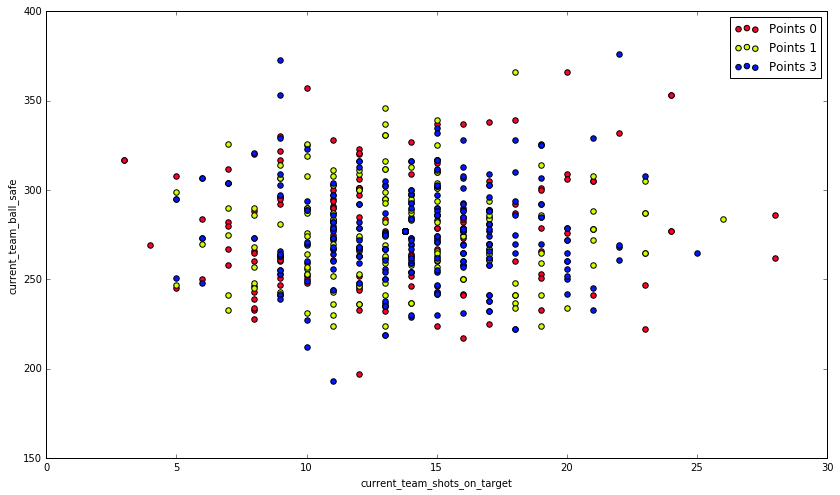

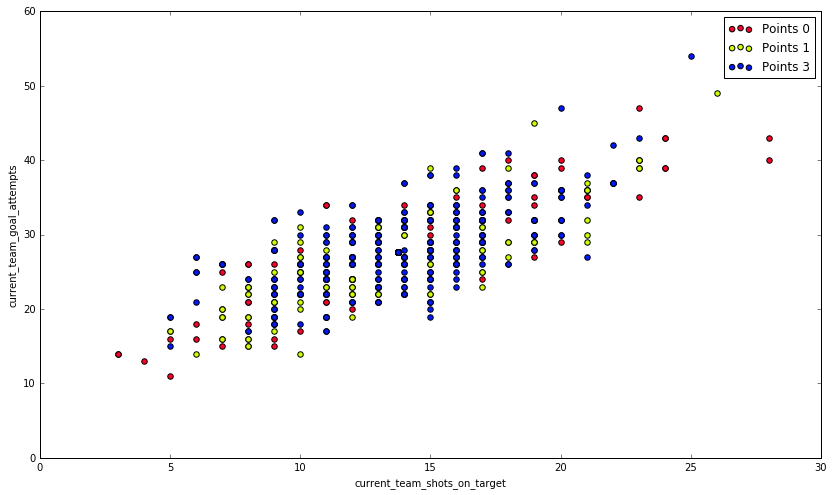

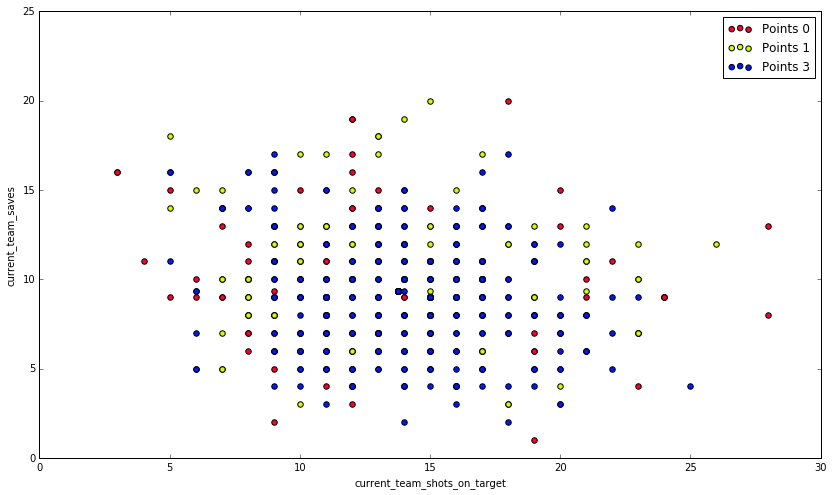

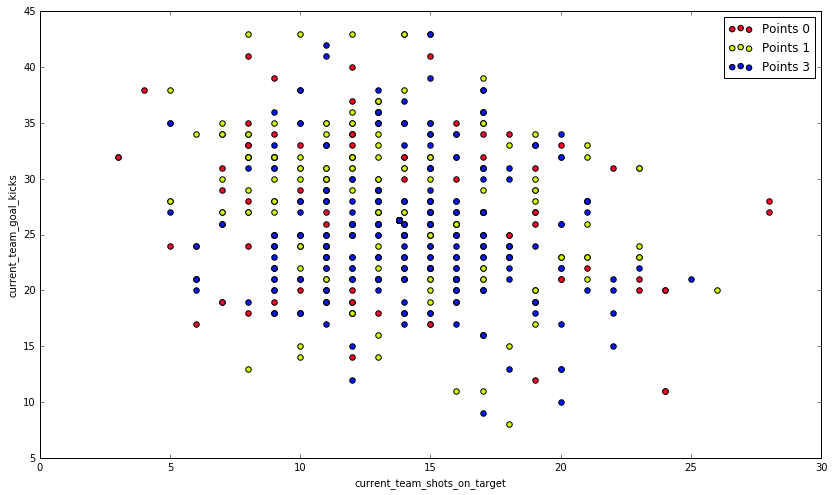

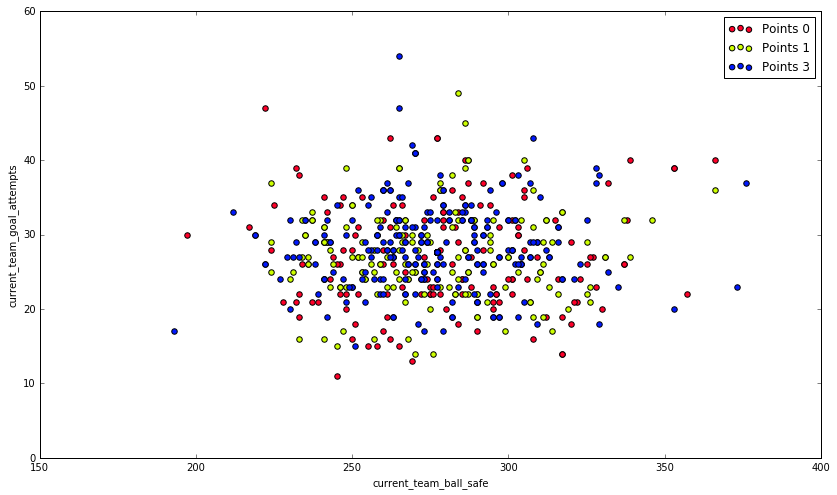

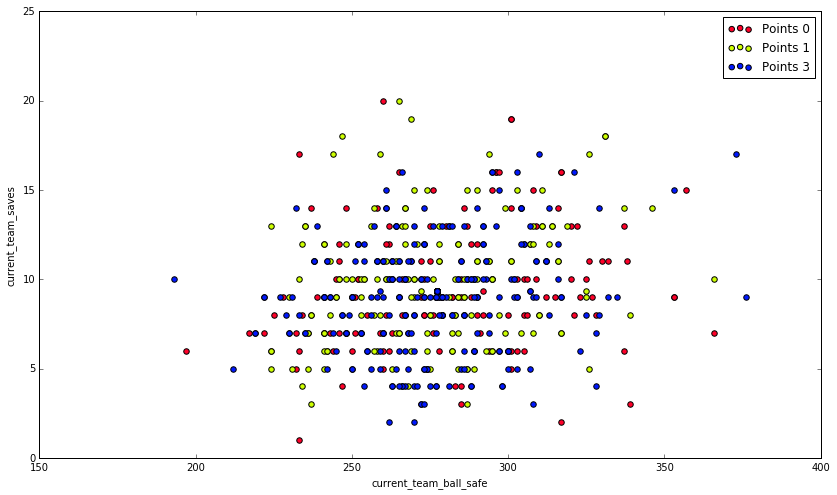

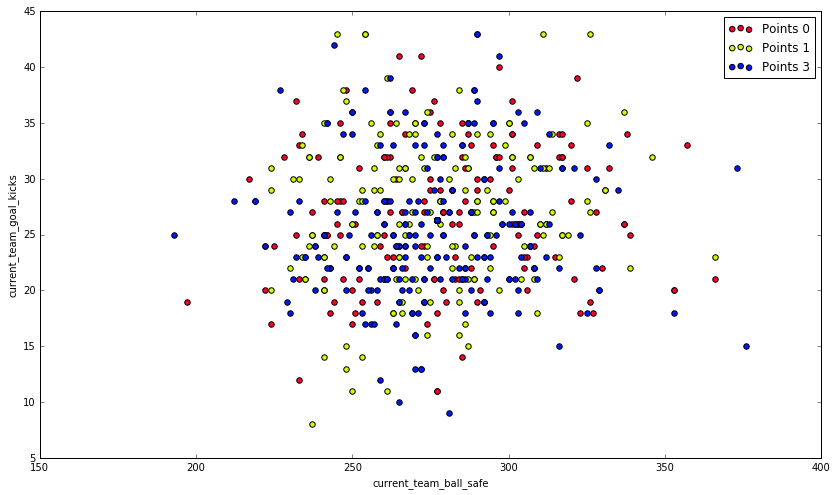

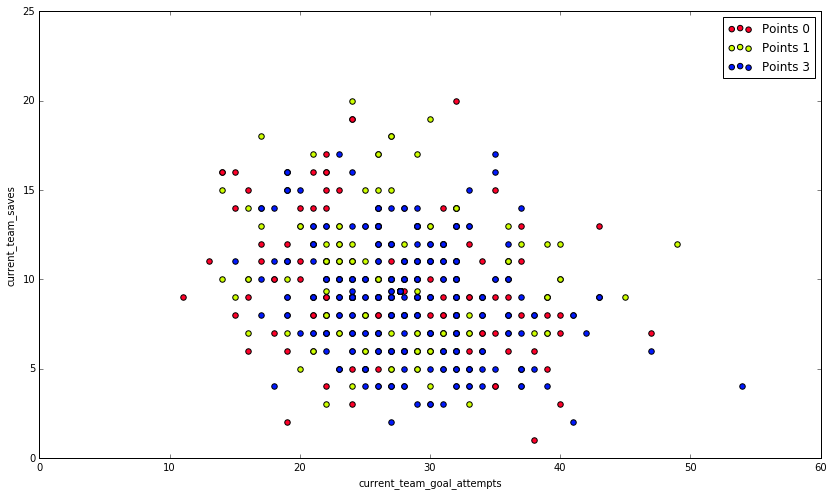

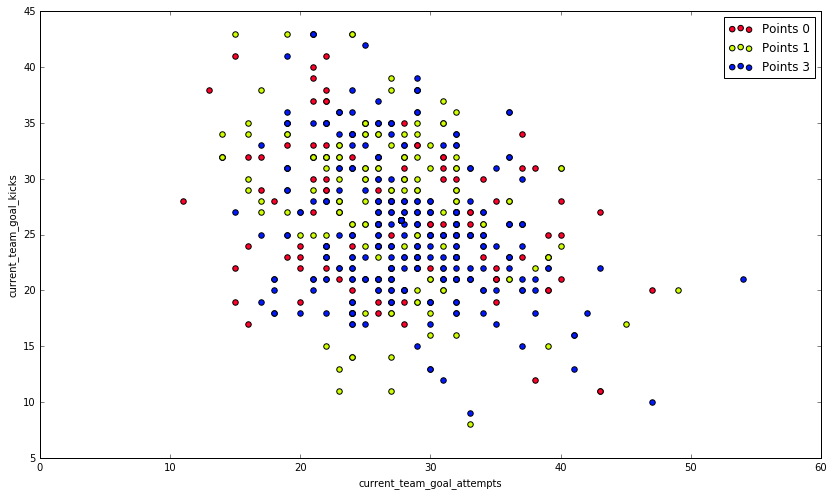

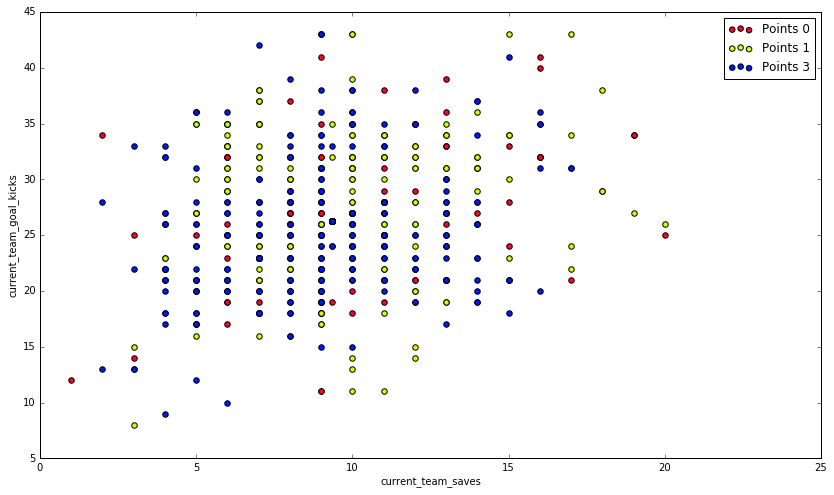

In [10]:
# Leaving out 'Shots_Total' since it's mostly the same number as 'Goal_Attempts'
columns = ['current_team_possession', 'current_team_attacks', 'current_team_dangerous_attacks', 'current_team_yellow_cards', 'current_team_corner_kicks', 'current_team_shots_on_target',
           'current_team_ball_safe', 'current_team_goal_attempts', 'current_team_saves', 'current_team_goal_kicks',
           'points']
features = raw_data[columns]
display(features.head())

for c in range(len(columns)):
    if c < (len(columns)-1): 
        compare = (len(columns)-2) - c
        for x in (range(compare)):
            fig, ax = plt.subplots(figsize = (14,8))
            cmap = cm.get_cmap('gist_rainbow')

            for i, cluster in features.groupby('points'):   
                cluster.plot(ax = ax, kind = 'scatter', x = columns[c], y = columns[x+1+c], 
                    color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);


,home_attacks,home_ball_safe,home_points
0,143,115,0
2,77,83,0
3,65,66,1
4,88,75,3
5,93,87,3


(430, 3)


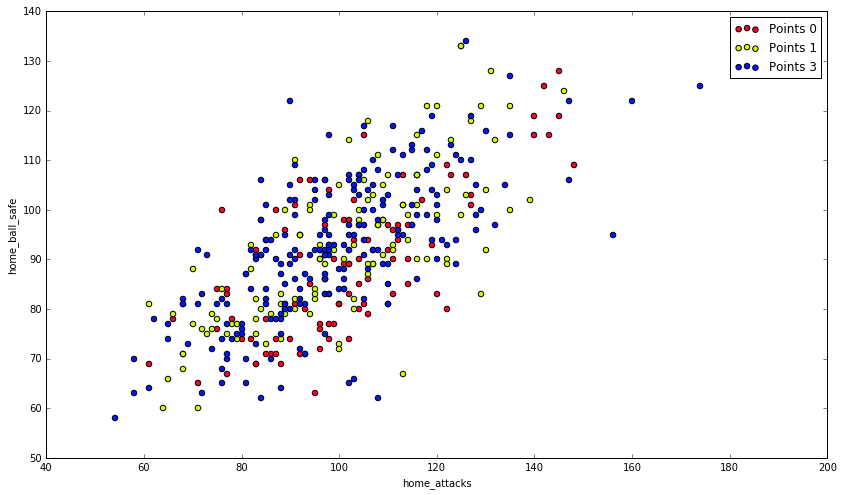

In [12]:
#print(match_details)
cols = ['home_attacks', 'home_ball_safe', 'home_points']
rels = match_details[cols]
rels = rels.dropna()
display(rels.head())
print(rels.shape)

fig, ax = plt.subplots(figsize = (14,8))
cmap = cm.get_cmap('gist_rainbow')

for i, cluster in rels.groupby('home_points'):   
    cluster.plot(ax = ax, kind = 'scatter', x = 'home_attacks', y = 'home_ball_safe', 
                    color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);

,away_attacks,away_ball_safe,away_points
0,111.0,128.0,3
2,103.0,75.0,3
3,74.0,75.0,1
4,86.0,80.0,0
5,92.0,91.0,0


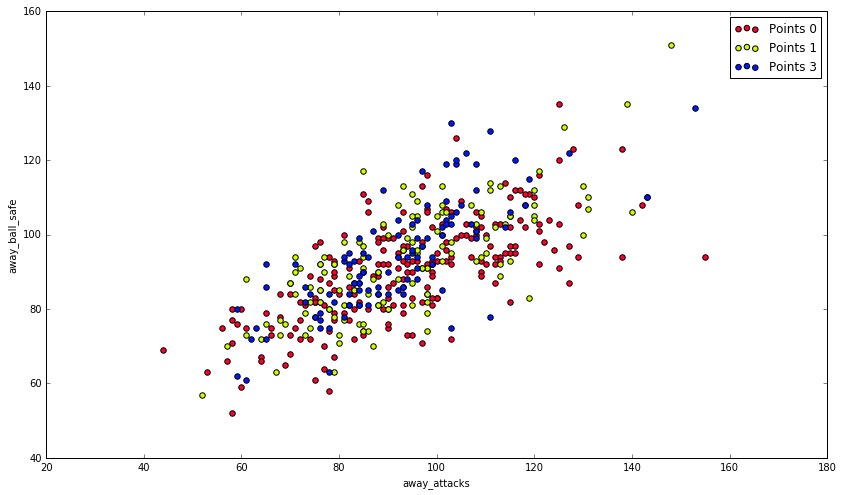

In [11]:
#print(match_details)
cols = ['away_attacks', 'away_ball_safe', 'away_points']
rels = match_details[cols]
rels = rels.dropna()
display(rels.head())

fig, ax = plt.subplots(figsize = (14,8))
cmap = cm.get_cmap('gist_rainbow')

for i, cluster in rels.groupby('away_points'):   
    cluster.plot(ax = ax, kind = 'scatter', x = 'away_attacks', y = 'away_ball_safe', 
                    color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);

home_score,0,1,2,3,4,5,6,Total
home_goal_attempts,,,,,,,,
0.0,1,0,0,0,0,0,0,1
1.0,1,1,0,0,0,0,0,2
2.0,1,1,0,0,0,0,0,2
3.0,1,4,2,0,0,0,0,7
4.0,1,5,1,0,0,0,0,7
5.0,7,7,5,1,0,0,0,20
6.0,8,10,7,4,1,1,0,31
7.0,9,11,6,2,3,0,0,31
8.0,15,16,7,2,1,0,0,41


home_score,0,1,2,3,4,5,6,Total
home_goal_attempts,,,,,,,,
8.0,15,16,7,2,1,0,0,41
9.0,10,18,12,7,3,1,0,51
10.0,6,26,10,8,4,2,0,56
11.0,7,9,14,5,0,0,0,35
12.0,7,16,14,9,1,0,1,48
Total,45,85,57,31,9,3,1,231


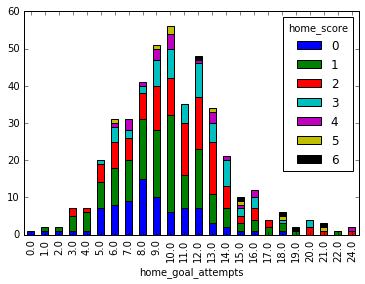

In [22]:
cols = ['home_goal_attempts', 'home_score', 'home_points']
rels = match_details[cols]
rels = rels.dropna()
# print(rels.groupby('home_shots_total').groups)
rels = rels.sort_values('home_goal_attempts')

a = pd.crosstab(rels['home_goal_attempts'], rels['home_score'])
a.plot(kind='bar', stacked=True)
a['Total'] = a.sum(axis=1)
a.loc['Total']= a.sum()
display(a)

b = pd.crosstab(rels['home_goal_attempts'], rels['home_score'])
b = b.loc[8:12]
b['Total'] = b.sum(axis=1)
b.loc['Total']= b.sum()
display(b)

home_score,0,1,2,3,4,5,6,Total
home_shots_on_target,,,,,,,,
2.0,19,20,7,1,0,0,0,47
3.0,19,25,9,2,0,0,0,55
4.0,14,25,20,6,1,0,0,66
5.0,8,28,21,11,4,1,0,73
6.0,4,17,17,10,2,1,0,51
7.0,2,17,16,12,4,1,0,52
Total,66,132,90,42,11,3,0,344


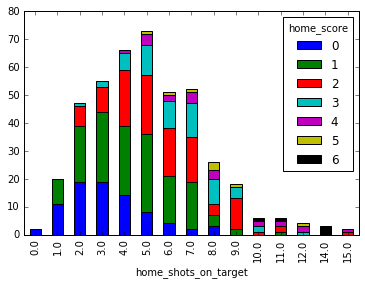

In [27]:
cols = ['home_shots_on_target', 'home_score', 'home_points']
rels = match_details[cols]
rels = rels.dropna()

rels = rels.sort_values('home_shots_on_target')

temp = pd.crosstab(rels['home_shots_on_target'], rels['home_score'])
temp.plot(kind='bar', stacked=True)

b = pd.crosstab(rels['home_shots_on_target'], rels['home_score'])
b = b.loc[2:7]
b['Total'] = b.sum(axis=1)
b.loc['Total']= b.sum()
display(b)

away_score,0,1,2,3,4,5,6,Total
away_goal_attempts,,,,,,,,
1.0,2,0,0,0,0,0,0,2
2.0,1,3,0,0,0,0,0,4
3.0,2,8,1,0,0,0,0,11
4.0,14,13,5,1,1,0,0,34
5.0,19,14,5,0,1,0,0,39
6.0,19,21,7,1,0,0,0,48
7.0,16,29,13,5,3,0,0,66
8.0,16,10,10,6,0,0,0,42
9.0,17,17,12,4,2,1,0,53


away_score,0,1,2,3,4,5,6,Total
away_goal_attempts,,,,,,,,
6.0,19,21,7,1,0,0,0,48
7.0,16,29,13,5,3,0,0,66
8.0,16,10,10,6,0,0,0,42
9.0,17,17,12,4,2,1,0,53
10.0,13,12,15,4,1,1,0,46
Total,81,89,57,20,6,2,0,255


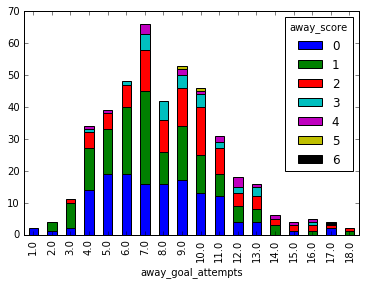

In [23]:
cols = ['away_goal_attempts', 'away_score', 'away_points']
rels = match_details[cols]
rels = rels.dropna()

a = pd.crosstab(rels['away_goal_attempts'], rels['away_score'])
a.plot(kind='bar', stacked=True)
a['Total'] = a.sum(axis=1)
a.loc['Total']= a.sum()
display(a)


b = pd.crosstab(rels['away_goal_attempts'], rels['away_score'])
b = b.loc[6:10]
b['Total'] = b.sum(axis=1)
b.loc['Total']= b.sum()
display(b)

away_score,0,1,2,3,4,5,6,Total
away_shots_on_target,,,,,,,,
2.0,28,34,3,1,0,0,0,66
3.0,32,32,16,1,0,0,0,81
4.0,21,27,19,4,2,0,0,73
5.0,16,21,21,6,3,0,0,67
6.0,10,14,16,10,3,0,0,53
7.0,2,2,10,3,3,1,0,21
Total,109,130,85,25,11,1,0,361


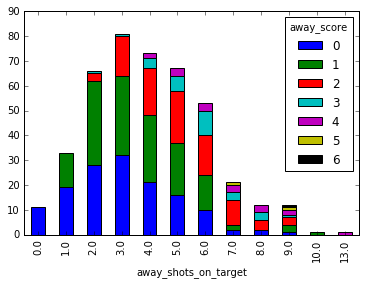

In [30]:
cols = ['away_shots_on_target', 'away_score', 'away_points']
rels = match_details[cols]
rels = rels.dropna()

rels = rels.sort_values('away_shots_on_target')

temp = pd.crosstab(rels['away_shots_on_target'], rels['away_score'])
temp.plot(kind='bar', stacked=True)

b = pd.crosstab(rels['away_shots_on_target'], rels['away_score'])
b = b.loc[2:7]
b['Total'] = b.sum(axis=1)
b.loc['Total']= b.sum()
display(b)

In [18]:
conv_points = match_details
def set_group(goals):
    if goals >= 2:
        return 1
    elif goals < 2:
        return 0
    
conv_points['home_converted_score'] = conv_points.apply(lambda row: set_group(row['home_score']), axis=1)
conv_points = conv_points.drop('home_score', 1)

conv_points['away_converted_score'] = conv_points.apply(lambda row: set_group(row['away_score']), axis=1)
conv_points = conv_points.drop('away_score', 1) 

In [19]:
away_points = pd.crosstab(conv_points['away_converted_score'], 
            conv_points.replace({'away_points': {0: 'Lose', 1: 'Tie', 3: 'Win'}})['away_points']).apply(lambda r: r/len(match_details), axis=1)

away_points['Total'] = away_points.sum(axis=1)
away_points.loc['Total']= away_points.sum()
display(away_points)

away_points,Lose,Tie,Win,Total
away_converted_score,,,,
0,0.414097,0.211454,0.046256,0.671806
1,0.066079,0.077093,0.185022,0.328194
Total,0.480176,0.288546,0.231278,1.000000


In [20]:
home_points = pd.crosstab(conv_points['home_converted_score'], 
            conv_points.replace({'home_points': {0: 'Lose', 1: 'Tie', 3: 'Win'}})['home_points']).apply(lambda r: r/len(match_details), axis=1)
home_points['Total'] = home_points.sum(axis=1)
home_points.loc['Total']= home_points.sum()
display(home_points)

home_points,Lose,Tie,Win,Total
home_converted_score,,,,
0,0.209251,0.211454,0.116740,0.537445
1,0.022026,0.077093,0.363436,0.462555
Total,0.231278,0.288546,0.480176,1.000000
